# Flying Object Classifier
An approach to classify a flying object (drone,bird or plane) from pictures. Final project for Data Science bootcamp organized by Sages.

## Table of contents

1. Abstract

2. About dataset

3. Prerequisites

4. Data Preprocessing

5. Definition of Image Data Generator

6. Model assembling and training

7. Comparision: NASNetLarge vs Inception

8. Making predictions on new images

9. Summary


## 1. Abstract

The goal of the project is to recognize the flying object which is either drone, bird or plane from a photo taken by the user. The main idea is to prepare a model using transfer learning from other already trained models and train just the decision layer of a neural network. For this purpose ImageDataGenerator is used which generates batches of tensor-image data with real time image augmentation.

As base models, two well know CNN are used: **NASNetLarge** and **Inception**. Each of them has a well trained convolutional layer, which is used for recognition of different objects and is an input for decision layer, where the classification of an object takes place.

## 2. About dataset

[Drone Dataset](https://www.kaggle.com/dasmehdixtr/drone-dataset-uav) dataset of UAV objects collected by Mehdi Özel for a UAV Competition which contains 1359 photos of drones. Some of them (all .png files) were removed from the dataset because were causing problems during model training phase.

[Birds Dataset](https://www.kaggle.com/gpiosenka/100-bird-species) dataset of of 285 bird species containing 40930 training images and 1425 test images. Dataset was carefully filtered to select a pictures reflecting mainly flying birds which were done from higher distance. Despite all efforts, some pictures of non-flying birds taken from close distance are also in the dataset (however they are in the minority).

[Planes Dataset](https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/) benchmark dataset for the fine grained visual categorization of aircraft containing 10200 images of different aircrafts. Again dataset was filtered to remove most of the non-flying aircraft pictures taken from the closer distance so they can better reflect the purpose of the project.

## 3. Prerequisites 

Import of the necessary libraries

In [19]:
import os
import shutil
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing.image import ImageDataGenerator #wczytuje dane z dysku i wysyla do sieci
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout 

## 4. Data Preprocessing

Data are divided into 3 directories: Train, Validation and Test. Test data contains selected and unique pictures from google.

Data storage directories

In [20]:
train_data_dir='/Users/hubertradom/DS_Project/Dataset/Images/flying_objects/train'
val_data_dir='/Users/hubertradom/DS_Project/Dataset/Images/flying_objects/validation'
test_data_dir='/Users/hubertradom/DS_Project/Dataset/Images/flying_objects/test'

In [21]:
#Data preprocessing
#Train/Val split definition

Train and Validation data are gathered in the 3 folders where all the pictures of each category are stored. The split between Train and Validation data is done based on random selection of certained defined number of pictures. Around 10% of pictures are intended for validation of a model.

Source and destination data directories

In [22]:
drones_dirsrc='/Users/hubertradom/DS_Project/Dataset/Images/all_drones'
drones_traindst=train_data_dir+'/drones'
drones_valdst=val_data_dir+'/drones'


birds_dirsrc='/Users/hubertradom/DS_Project/Dataset/Images/all_birds'
birds_traindst=train_data_dir+'/birds'
birds_valdst=val_data_dir+'/birds'


planes_dirsrc='/Users/hubertradom/DS_Project/Dataset/Images/all_planes'
planes_traindst=train_data_dir+'/planes'
planes_valdst=val_data_dir+'/planes'


Number of validation data:

In [ ]:
n_droneval_data=150
n_birdval_data=150
n_planeval_data=250

Definition of functions splitting the data:

In [23]:
def duplicate_folder(input_dir):
    input_dir_copy=input_dir+'_copy'
    if os.path.isdir(input_dir_copy):
        shutil.rmtree(input_dir_copy)
    shutil.copytree(input_dir, input_dir_copy)
    return input_dir_copy

def get_file_list(input_dir):
    input_dir_copy=input_dir+'_copy'
    input_dir_copy=duplicate_folder(input_dir)
    return [file for file in os.listdir(input_dir_copy) if os.path.isfile(os.path.join(input_dir_copy, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def move_files_train(random_files, input_dir, output_dir):
    input_dir_copy=input_dir+'_copy'
    if os.path.isdir(output_dir):
        shutil.rmtree(output_dir)        
    os.mkdir(output_dir)
    for file in random_files:
        shutil.move(os.path.join(input_dir_copy, file), output_dir)

def create_val_folder(input_dir, output_dir, N):
    duplicate_folder(input_dir)
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    move_files_train(random_files, input_dir, output_dir)

def create_train_folder(input_dir, output_dir):
    input_dir_copy=input_dir+'_copy'
    if os.path.isdir(output_dir):
        shutil.rmtree(output_dir)
        os.mkdir(output_dir)
    else:
        os.mkdir(output_dir)
    filenames=os.listdir(input_dir_copy)
    for file in filenames:
        shutil.move(os.path.join(input_dir_copy,file), output_dir)
    shutil.rmtree(input_dir_copy)


Split the data into val and train folders being an input to ImageDataGenerator

In [24]:
create_val_folder(drones_dirsrc,drones_valdst,n_droneval_data)
create_val_folder(birds_dirsrc,birds_valdst,n_birdval_data)
create_val_folder(planes_dirsrc,planes_valdst,n_planeval_data)

In [25]:
create_train_folder(drones_dirsrc, drones_traindst)
create_train_folder(birds_dirsrc, birds_traindst)
create_train_folder(planes_dirsrc, planes_traindst)

## 5. Definition of ImageDataGenerator

Train Generator Variables

Pictures are cropped to the bigger size from the ones requested by the base models. In this case it is 331x331px (as requested by the NASNetLarge model).

In [27]:
batch_size=32
imagesize = (331,331,3)

Data augumentation and scaling

As mentioned in the abstract, ImageDataGenerator allows for real time image augmentation. It creates a connection between the image directory and CNN and train each epoch with the number of pictures equal to batch size. Data augmentation allows for diversification of the training data, therefore it is common approach to use it.

In [29]:
train_datagen=ImageDataGenerator(rescale=1/255,
                                zoom_range=[0.5,1.5],
                                rotation_range=45, 
                                horizontal_flip=True) 

val_datagen=ImageDataGenerator(rescale=1/255)

test_datagen=ImageDataGenerator(rescale=1/255)

Flow definition for all 3 sets of data

In [31]:
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=imagesize[:2],
                                                  batch_size=batch_size,
                                                  class_mode='categorical')
val_generator=val_datagen.flow_from_directory(val_data_dir,
                                                  target_size=imagesize[:2],
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')
test_generator=test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=imagesize[:2],
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 5112 images belonging to 3 classes.
Found 548 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


Utilization of DataImageGenerator for definition of variables used later on in training and testing phase:

In [32]:
n_classes=len(train_generator.class_indices)
n_train_samples=len(train_generator.filenames)
n_test_samples=len(test_generator.filenames)
class_names=test_generator.class_indices

## 6. Model Assembling and Training

Base models convolutional layer download. In this project two models are used (both available in keras): **NASNetLarge** and **InceptionV3**. The layer that return prediction is omitted.

In [34]:
base_inception=inception_v3.InceptionV3 (weights='imagenet',include_top=False,input_shape=imagesize)

In [35]:
base_NASNetLarge=NASNetLarge(weights='imagenet',include_top=False,input_shape=imagesize) #pobieramy siec z wagami

343621632/343610240 [==============================] - 44s 0us/step


Definition od decision layer. This model takes features extracted by base models as an input. The output is a Dense layer with 3 neurons (same as the number of classes) with softmax activation function, which allows for probability estimation of each predicted class.

In [38]:
def top_model():
    top_model=Sequential()
    top_model.add(Flatten())#najpierw musimy rozwinac to co tamta siec zwraca
    top_model.add(Dense(1024, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(n_classes, activation='softmax'))
    return top_model

In [39]:
top_model_inception=top_model()
top_model_NASNetLarge=top_model()

Model definition - Convolutional and Decision layers assembly. 

Note that the convolutional layers are not trained and already trained weights are used for image recognition

In [41]:
def model_definition(base_model,top_model):
    model=Sequential()
    model.add(base_model)
    model.add(top_model)
    model.layers[0].trainable=False
    
    model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics='categorical_accuracy')

    return model

In [42]:
inception_model=model_definition(base_inception,top_model_inception)
NASNetLarge_model=model_definition(base_NASNetLarge,top_model_NASNetLarge)

In [43]:
inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 9, 9, 2048)        21802784  
_________________________________________________________________
sequential (Sequential)      (None, 3)                 170396675 
Total params: 192,199,459
Trainable params: 170,396,675
Non-trainable params: 21,802,784
_________________________________________________________________


In [44]:
NASNetLarge_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 500108291 
Total params: 585,025,109
Trainable params: 500,108,291
Non-trainable params: 84,916,818
_________________________________________________________________


Inception and NASNetLarge models training

In [46]:
def train_model(model):
    early_stopping=EarlyStopping(monitor='val_categorical_accuracy',
                                 patience=10,
                                 restore_best_weights=True)
    
    history=model.fit(train_generator,
                       steps_per_epoch=n_train_samples//batch_size,
                       validation_data=val_generator,
                       batch_size=batch_size,
                       epochs=1000,
                       callbacks=early_stopping)
    return history

In [47]:
history_inception=train_model(inception_model)

Epoch 1/1000


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


159/159 [==============================] - 679s 4s/step - loss: 7.8400 - categorical_accuracy: 0.9033 - val_loss: 0.2376 - val_categorical_accuracy: 0.9945
Epoch 2/1000
159/159 [==============================] - 856s 5s/step - loss: 2.1146 - categorical_accuracy: 0.9549 - val_loss: 0.3063 - val_categorical_accuracy: 0.9872
Epoch 3/1000
159/159 [==============================] - 691s 4s/step - loss: 1.5289 - categorical_accuracy: 0.9618 - val_loss: 0.8821 - val_categorical_accuracy: 0.9745
Epoch 4/1000
159/159 [==============================] - 565s 4s/step - loss: 1.3013 - categorical_accuracy: 0.9646 - val_loss: 0.1406 - val_categorical_accuracy: 0.9891
Epoch 5/1000
159/159 [==============================] - 568s 4s/step - loss: 0.6734 - categorical_accuracy: 0.9736 - val_loss: 0.0641 - val_categorical_accuracy: 0.9945
Epoch 6/1000
159/159 [==============================] - 564s 4s/step - loss: 0.4871 - categorical_accuracy: 0.9778 - val_loss: 0.1326 - val_categorical_accuracy: 0.9672

In [48]:
history_NASNetLarge=train_model(NASNetLarge_model)

Epoch 1/1000
159/159 [==============================] - 2316s 14s/step - loss: 8.7660 - categorical_accuracy: 0.9358 - val_loss: 0.6795 - val_categorical_accuracy: 0.9872
Epoch 2/1000
159/159 [==============================] - 2250s 14s/step - loss: 4.2094 - categorical_accuracy: 0.9661 - val_loss: 0.6088 - val_categorical_accuracy: 0.9909
Epoch 3/1000
159/159 [==============================] - 2264s 14s/step - loss: 2.7693 - categorical_accuracy: 0.9719 - val_loss: 0.5495 - val_categorical_accuracy: 0.9927
Epoch 4/1000
159/159 [==============================] - 2264s 14s/step - loss: 1.6092 - categorical_accuracy: 0.9785 - val_loss: 0.2493 - val_categorical_accuracy: 0.9909
Epoch 5/1000
159/159 [==============================] - 2338s 15s/step - loss: 1.3509 - categorical_accuracy: 0.9781 - val_loss: 0.4893 - val_categorical_accuracy: 0.9891
Epoch 6/1000
159/159 [==============================] - 2274s 14s/step - loss: 1.8091 - categorical_accuracy: 0.9758 - val_loss: 0.3568 - val_cat

## 7. Comparision: NASNetLarge vs Inception

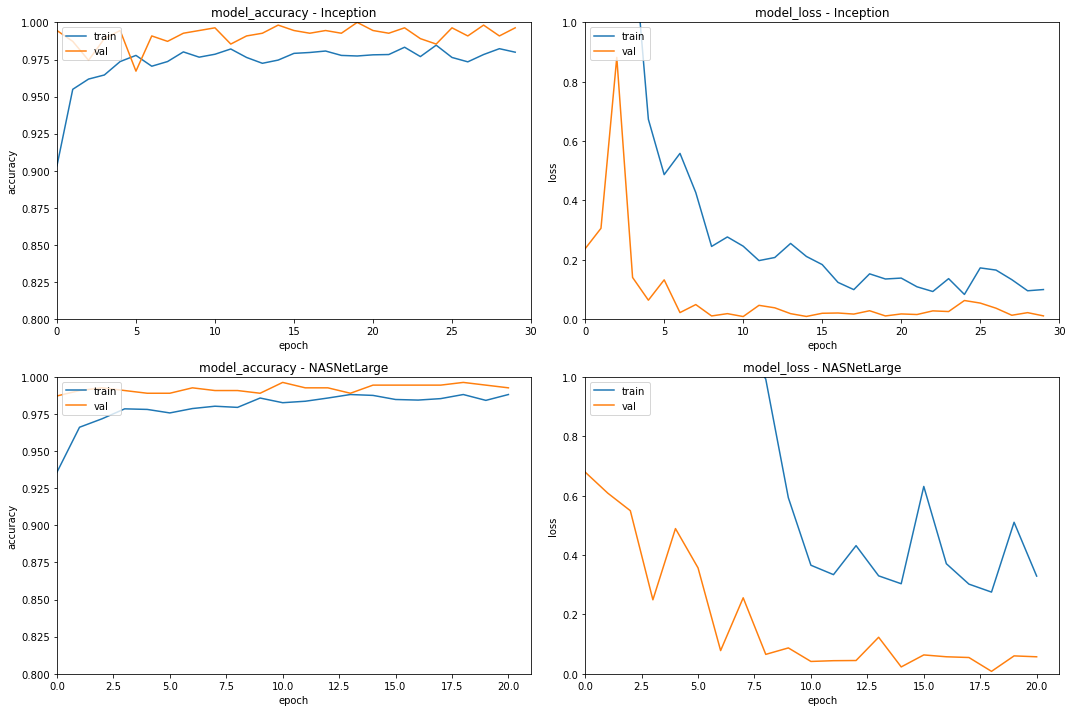

In [69]:
fig=plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.axis([0,30,0.8,1])
plt.plot(history_inception.history['categorical_accuracy'])
plt.plot(history_inception.history['val_categorical_accuracy'])
plt.title('model_accuracy - Inception')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')

plt.subplot(2,2,2)
plt.axis([0,30,0,1])
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('model_loss - Inception')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()

plt.subplot(2,2,3)
plt.axis([0,21,0.8,1])
plt.plot(history_NASNetLarge.history['categorical_accuracy'])
plt.plot(history_NASNetLarge.history['val_categorical_accuracy'])
plt.title('model_accuracy - NASNetLarge')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')

plt.subplot(2,2,4)
plt.axis([0,21,0,1])
plt.plot(history_NASNetLarge.history['loss'])
plt.plot(history_NASNetLarge.history['val_loss'])
plt.title('model_loss - NASNetLarge')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()

Model evaluation based on validation data

In [91]:
incetption_val_loss,inception_val_acc=inception_model.evaluate(val_generator)
NASNetLarge_val_loss,NASNetLarge_val_acc=NASNetLarge_model.evaluate(val_generator)

 6/18 [=========>....................] - ETA: 21s - loss: 0.0055 - categorical_accuracy: 1.0000  

/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


18/18 [==============================] - 174s 9s/step - loss: 0.0416 - categorical_accuracy: 0.9964


In [88]:
inception_test_loss,inception_test_acc=inception_model.evaluate(test_generator)
NASNetLarge_test_loss,NASNetLarge_test_acc=NASNetLarge_model.evaluate(test_generator)

4/4 [==============================] - 36s 9s/step - loss: 7.8060 - categorical_accuracy: 0.8148


In [100]:
multicol1_inception = pd.MultiIndex.from_tuples([('Inception_model', 'validation'),
                                       ('Inception_model', 'test')])
df_model_inception = pd.DataFrame([[inception_val_acc, inception_test_acc], [incetption_val_loss, inception_test_loss]],
                                    index=['accuracy', 'loss'],
                                    columns=multicol1_inception)
multicol1_NASNetLarge = pd.MultiIndex.from_tuples([('NASNetLarge_model', 'validation'),
                                       ('NASNetLarge_model', 'test')])
df_model_NASNetLarge = pd.DataFrame([[NASNetLarge_val_acc, NASNetLarge_test_acc], [NASNetLarge_val_loss, NASNetLarge_test_loss]],
                                    index=['accuracy', 'loss'],
                                    columns=multicol1_NASNetLarge)
df_model_comparison=pd.concat((df_model_inception,df_model_NASNetLarge),axis=1)
df_model_comparison

Inception_model           NASNetLarge_model          
              validation      test        validation      test
accuracy        1.000000  0.861111           0.99635  0.814815
loss            0.010967  0.535341           0.04162  7.806019

As shown in the pictures and model evaluations above, it looks like features extracted by Inception model give better results in terms of higher categorical accuracy and lower validation loss metric, than the ones extracted from NASNetLarge model. It takes up to 10 epochs to train both models. After this threshold, there is no significant change in both categorical accuracy and validation loss metric. 

Therefore for the final quality check of the model, inception_v3 model is selected

Checking the confidence of the model by comparing predictions with true labels

In [101]:
y_prob=inception_model.predict(test_generator) #making predictions for all the test data
y_prob

array([[1.00000000e+00, 2.35718384e-30, 1.91245663e-36],
       [1.00000000e+00, 2.23508122e-11, 1.98063554e-16],
       [1.00000000e+00, 4.52452251e-26, 1.43943129e-34],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99140382e-01, 2.63327034e-04, 5.96206111e-04],
       [8.84313643e-01, 6.23758584e-02, 5.33105060e-02],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.84313643e-01, 6.23758584e-02, 5.33105060e-02],
       [1.00000000e+00, 3.00472398e-22, 5.07196942e-31],
       [1.00000000e+00, 5.21031380e-27, 4.38168561e-35],
       [1.00000000e+00, 2.64340330e-18, 7.21754924e-25],
       [1.00000000e+00, 2.30990398e-26, 3.17455311e-37],
       [1.00000000e+00, 5.55841178e-16, 1.99741500e-20],
       [1.43007515e-03, 4.63745221e-02, 9.52195406e-01],
       [9.94688511e-01, 2.55796104e-03, 2.75351945e-03],
       [9.99999881e-01, 8.63965184e-08, 5.34302425e-09],
       [6.46928310e-01, 1.19143263e-01, 2.33928487e-01],
       [1.00000000e+00, 5.56027

In [103]:
y_pred = y_prob.argmax(axis=1) #extracting the label of a class having the highest confidence value
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2])

In [78]:
y_true=test_generator.labels #extracting true class labels
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

Confusion matrix - allows for visualisation of model performance. Interesting is that planes are more often confused with drones than birds.

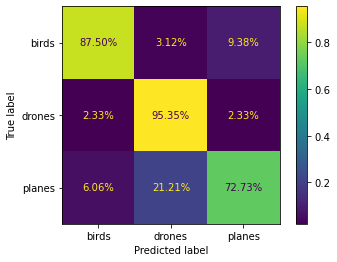

In [107]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_pred, y_true, normalize='true', values_format='.2%',display_labels=list(class_names.keys()));

## 8. Making predictions on new images

Extraction of predicted and true labels for each of an image

In [82]:
n=len(test_generator.labels)
test_labels=[]
test_predictions=[]
test_data=[]
for data,label in test_generator:
    test_predictions.extend(inception_model.predict(data))
    test_labels.extend(label)
    test_data.extend(data)
    if len(test_predictions)==n:
        break

Comparison of true and predicted data for validation set

In [110]:
df_labels=pd.DataFrame(np.row_stack(test_labels), columns=['Birds_true','Drones_true','Planes_true'])

df_predictions=pd.DataFrame(np.row_stack(test_predictions), columns=['Birds_pred','Drones_pred','Planes_pred'])
df_comparison=pd.concat((df_labels,df_predictions),axis=1)
df_comparison

,Birds_true,Drones_true,Planes_true,Birds_pred,Drones_pred,Planes_pred
0,1.0,0.0,0.0,1.000000e+00,2.357184e-30,1.912457e-36
1,1.0,0.0,0.0,1.000000e+00,2.235081e-11,1.980636e-16
2,1.0,0.0,0.0,1.000000e+00,4.524523e-26,1.439431e-34
3,1.0,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00
4,1.0,0.0,0.0,9.991404e-01,2.633270e-04,5.962061e-04
...,...,...,...,...,...,...
103,0.0,0.0,1.0,1.247285e-07,9.985673e-01,1.432463e-03
104,0.0,0.0,1.0,4.986488e-04,6.939582e-01,3.055431e-01
105,0.0,0.0,1.0,3.476482e-05,5.189926e-03,9.947753e-01
106,0.0,0.0,1.0,2.208374e-04,7.449785e-01,2.548006e-01


Plot of random selected images from test dataset with the probabilities of selection

In [120]:
def plot_image(i,test_predictions,test_labels,test_data):
    test_predictions,test_labels,test_data=test_predictions[i], test_labels[i],test_data[i]
    prob=test_predictions[np.argmax(test_predictions)]
    pred=np.argmax(test_predictions)
    true_labels=np.argmax(test_labels)
    image=test_data
    plt.imshow(image)
    
    class_names=val_generator.class_indices
    xlabel=f"True class: {list(class_names.keys())[int(true_labels)]}, (Predicted class: {list(class_names.keys())[int(pred)]}),\n Probability = {prob:0.2%}"
    plt.xlabel(xlabel)

In [121]:
def plot_value_array(i,test_predictions,test_labels):

    test_predictions,test_labels=test_predictions[i],test_labels[i]
    labels=["It's a Bird","It's a Drone","It's a Plane"]
    plt.xticks([0,1,2],labels,rotation=15)
    plt.yticks([])

    thisplot=plt.bar(range(3),test_predictions)
    
    plt.ylim([0,1])
    predicted_label=np.argmax(test_predictions)
    true_label=np.argmax(test_labels)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')
    

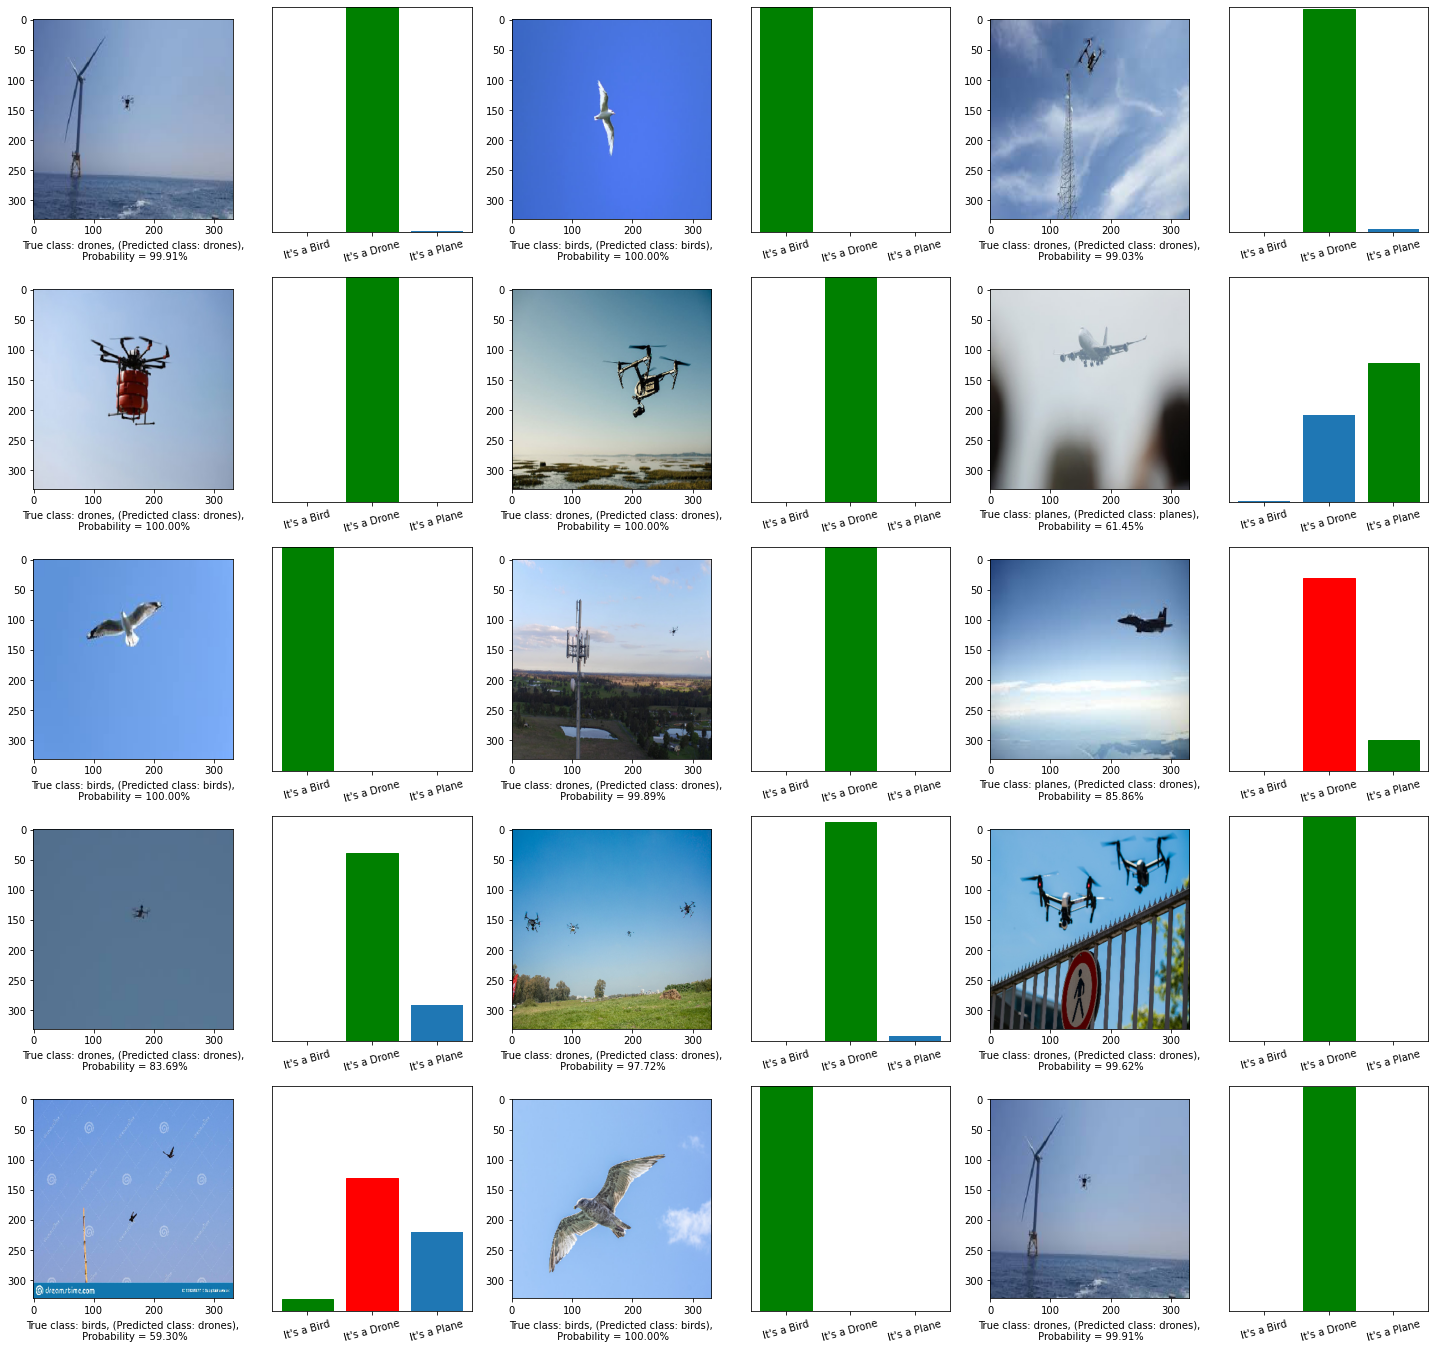

In [125]:
num_rows=5
num_cols=3
num_images=num_rows*num_cols
plt.figure(figsize=(5*num_rows,8*num_cols))


for i in range(num_images):
    n=random.sample(range(0,100),num_images)[i]
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_image(n,test_predictions,test_labels,test_data)
    plt.subplot(num_rows,2*num_cols,2*i+2)
    plot_value_array(n,test_predictions,test_labels)
plt.show()
    
    

## 9. Summary

The solution work with a good total accuracy of 86% for model based on features extracted by Inception network and 81% for model based on features extracted by NASNetLarge. 


In the future, it would be good to check if the accuracy of the model would increase in case the base model would have been trained for a couple of epochs or if some more augmentation methods would have been added.
